# Houseplant predction


## 1.Imports

In [49]:
import kagglehub
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## 2. Load data and Prepare


In [2]:
data_path = kagglehub.dataset_download("russellchan/healthy-and-wilted-houseplant-images")
print(data_path)

Using Colab cache for faster access to the 'healthy-and-wilted-houseplant-images' dataset.
/kaggle/input/healthy-and-wilted-houseplant-images


In [3]:
import os
import shutil

if os.path.exists("houseplant_images"):
    shutil.rmtree("houseplant_images")

shutil.copytree(data_path+"/houseplant_images", "houseplant_images")

'houseplant_images'

In [4]:
os.rename("houseplant_images/healthy", "houseplant_images/No_Need_Water")
os.rename("houseplant_images/wilted", "houseplant_images/Need_Water")

In [5]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

main_dir="./houseplant_images"
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

image_paths = []
labels = []
class_names = sorted(os.listdir(main_dir))
class_to_label = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(main_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_to_label[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print(f"Class Names: {class_names}")
print(f"Train set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")
print(f"Test set size: {len(test_paths)}")

def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Class Names: ['Need_Water', 'No_Need_Water']
Train set size: 723
Validation set size: 90
Test set size: 91


## 2.2 preprocessing

In [66]:
import random
import os

main_dir="./houseplant_images" # Assuming this is still the main directory
healthy_dir = os.path.join(main_dir, "No_Need_Water")
wilted_dir = os.path.join(main_dir, "Need_Water")

healthy_samples = random.sample(os.listdir(healthy_dir), 5)
wilted_samples = random.sample(os.listdir(wilted_dir), 5)

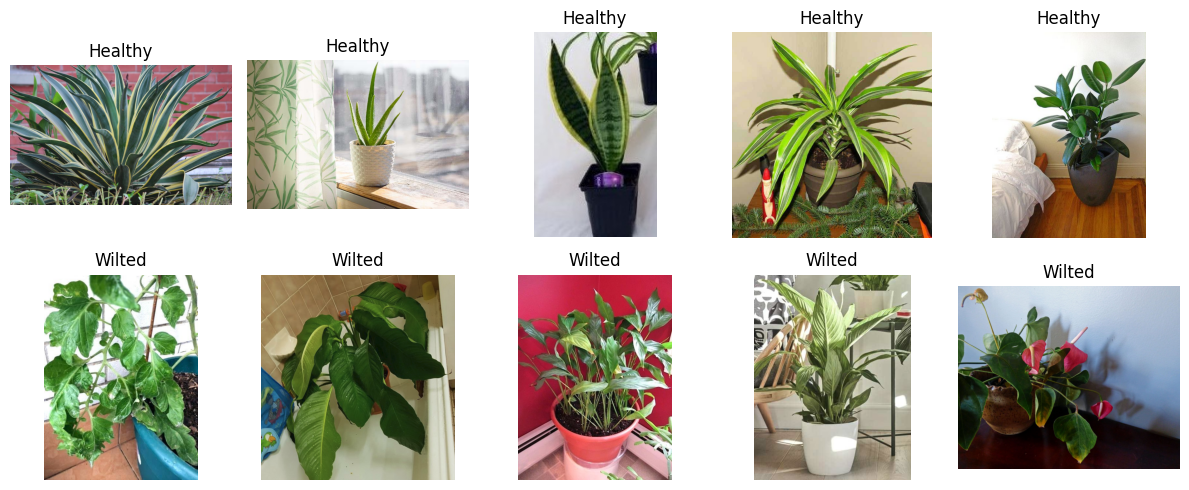

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

plt.figure(figsize=(12, 5))
for i, img_name in enumerate(healthy_samples):
    img_path = os.path.join(healthy_dir, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Healthy")

for i, img_name in enumerate(wilted_samples):
    img_path = os.path.join(wilted_dir, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Wilted")

plt.tight_layout()
plt.show()

In [70]:
from PIL import Image
import os

f = os.path.join(data_path, "houseplant_images", "healthy")
output_dir = '/content/healthy_resized'
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(f):
    f_img = os.path.join(f, file)
    img = Image.open(f_img)
    rgb_im = img.convert("RGB").resize((256, 256))
    rgb_im.save(os.path.join(output_dir, file))

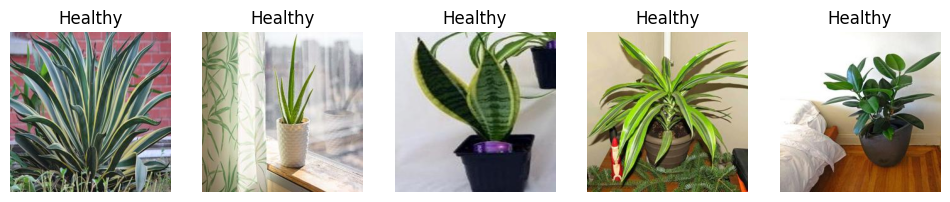

In [71]:
plt.figure(figsize=(12, 5))
for i, img_name in enumerate(healthy_samples):
    img_path = os.path.join(output_dir, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Healthy")

In [73]:
f = os.path.join(data_path, "houseplant_images", "wilted")
output_dir = '/content/wilted_resized'
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(f):
    f_img = os.path.join(f, file)
    img = Image.open(f_img)
    rgb_im = img.convert("RGB").resize((256, 256))
    rgb_im.save(os.path.join(output_dir, file))

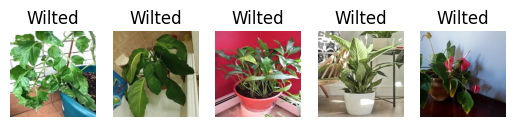

In [74]:
for i, img_name in enumerate(wilted_samples):
    img_path = os.path.join(output_dir, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Wilted")

## 3. plot Functions

These functions will plot our learning curves and evaluation metrics.

In [6]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def get_labels_and_predictions(model, test_dataset):
    y_true = []
    for _, labels in test_dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true).flatten()

    y_pred_proba = model.predict(test_dataset).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    return y_true, y_pred, y_pred_proba

def plot_evaluation_metrics(y_true, y_pred, y_pred_proba, model_name):
    """Prints classification report and plots CM and ROC curve."""
    print(f"\n--- Evaluation for {model_name} ---")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()



## 4. Data Augmentation



In [7]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.1, seed=SEED),
    layers.RandomZoom(0.1, seed=SEED)
], name="data_augmentation")

rescale = layers.Rescaling(1./255)

## 5. Model 2: Fine-Tuning VGG16

In [14]:
base_model_2 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model_2.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = rescale(inputs)
x = data_augmentation(x)
x = base_model_2(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model2 = models.Model(inputs, outputs, name="VGG16_Transfer_Learning")

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model2.summary()

Model: "VGG16_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5975 - auc: 0.6087 - loss: 0.7345
Epoch 1: val_accuracy improved from -inf to 0.72222, saving model to best_model_2_weights.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 390ms/step - accuracy: 0.5997 - auc: 0.6122 - loss: 0.7313 - val_accuracy: 0.7222 - val_auc: 0.8788 - val_loss: 0.4739
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7811 - auc: 0.8456 - loss: 0.4965
Epoch 2: val_accuracy improved from 0.72222 to 0.73333, saving model to best_model_2_weights.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7805 - auc: 0.8455 - loss: 0.4963 - val_accuracy: 0.7333 - val_auc: 0.8928 - val_loss: 0.5081
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8057 - auc: 0.8722 - loss: 0.4564
Epoch 3: val_accuracy improved from 0.73333 to 0.76667, saving model to best_model_2_weights.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.8059 - auc: 0.8725 - loss: 0.4559 - v

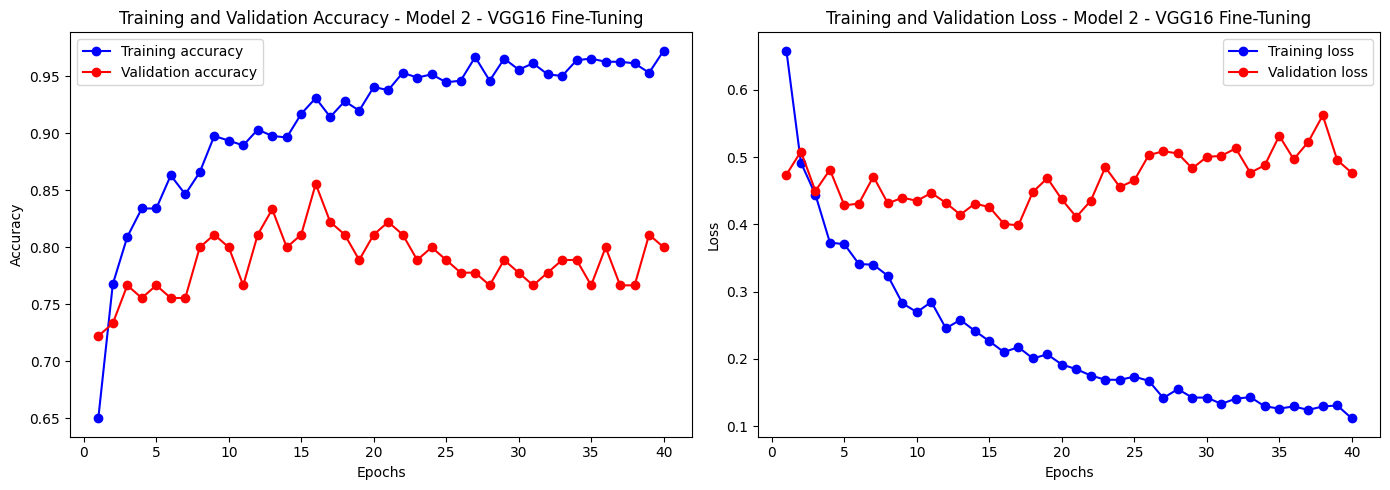

In [20]:
plot_history(history2, "Model 2 - VGG16 Fine-Tuning")

In [32]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = rescale(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

best_model_2 = models.Model(inputs, outputs, name="VGG16_Transfer_Learning")

best_model_2.load_weights("/content/best_model_2_weights.weights.h5")

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step

--- Evaluation for Model 2 - VGG16 Fine-Tuning ---

Classification Report:
               precision    recall  f1-score   support

   Need_Water       0.85      0.76      0.80        46
No_Need_Water       0.78      0.87      0.82        45

     accuracy                           0.81        91
    macro avg       0.82      0.81      0.81        91
 weighted avg       0.82      0.81      0.81        91



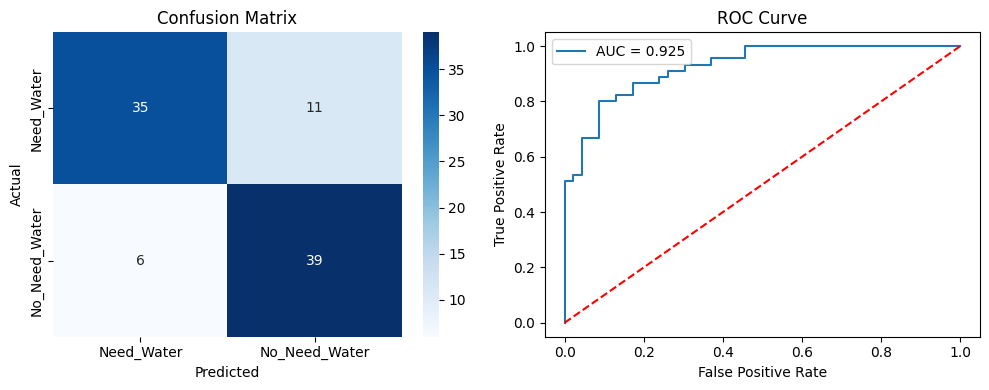

In [22]:
y_true2, y_pred2, y_pred_proba2 = get_labels_and_predictions(best_model_2, test_ds)
plot_evaluation_metrics(y_true2, y_pred2, y_pred_proba2, "Model 2 - VGG16 Fine-Tuning")

## 6. Test Model

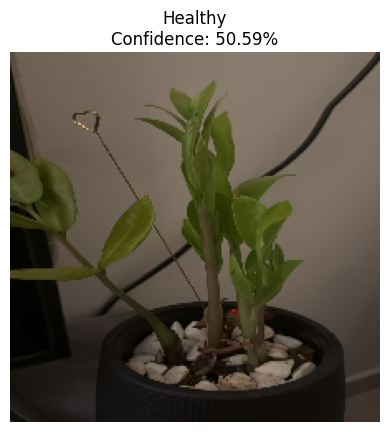

In [62]:
IMG_SIZE = 224
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build the model before loading weights
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model.load_weights("/content/best_model_2_weights.weights.h5")


def predict_plant(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)[0][0]
    label = "Healthy" if prediction >= 0.5 else "Wilted"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}\nConfidence: {confidence*100:.2f}%")
    plt.show()

predict_plant("/content/ral3.jpeg")

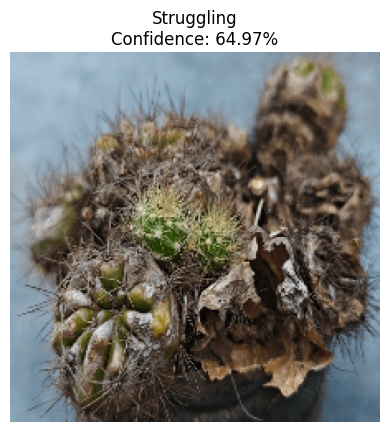

In [63]:
IMG_SIZE = 224
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build the model before loading weights
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model.load_weights("/content/best_model_2_weights.weights.h5")


def predict_plant(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)[0][0]
    if prediction <0.3 :

      label='Withered'

    elif  prediction <0.7:

      label='Struggling'

    else :

      label='healthy'

    confidence = prediction if prediction >= 0.5 else 1 - prediction

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}\nConfidence: {confidence*100:.2f}%")
    plt.show()

predict_plant("/content/testttt7.jpg")